In [1]:
import csv
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(0)

In [3]:
pd.set_option('display.max_rows', None)

## Overview

This notebook simulates the spread of an infection within a community that serves as a collection of private spaces (houses) and public spaces (landmarks). A random number of people belong to each house. Each simulation run represents a day. People leave their house at the start of each simulation run and visit one landmark during the day. Each individual may contract the virus by 1) being at a landmark where another infected person shows up or 2) from unknown "random" sources (for example, while communiting). At the end of each simulation run, all individuals return to their house. At this stage, an individual may be infected or exposed to the virus. If they are infected, they may infect other people in their house.

## Functions to execute distinct steps within a simulation run

This function builds a dictionary of houses in our virtual community. It takes in (x,y) coordinates for each house, minimum and maximum number of people per house, and probability that each individual has the contact tracing app installed.

In [4]:
def build_houses_dict(houses_x, houses_y, min_household, max_household, app_penetration):
    
    # initializing dictionary to store all houses
    houses_dict = {} 
    
    # starting count for total number of people
    total_people = 0 

    for i, coordinates in enumerate(zip(houses_x, houses_y)):
        
        # initiliazing a dictionary for a specific house
        houses_dict[i] = {} 
        
        # generating a random number of people in the house from a uniform distribution
        num_people = np.random.randint(low=min_household, high=max_household)
        total_people += num_people

        houses_dict[i]['coordinates'] = coordinates 
        houses_dict[i]['num_people'] = num_people
        
        # initialize house with no individual infected or exposed to the virus 
        # (and therefore no virus present in the house)
        houses_dict[i]['infected'] = np.zeros(num_people, dtype=bool)
        houses_dict[i]['exposed'] = np.zeros(num_people, dtype=bool)
        houses_dict[i]['infection_present'] = False
        
        # randomly determine whether each person has the contact tracing app installed
        houses_dict[i]['has_app'] = np.random.choice([False, True], 
                                                             p=[1-app_penetration, app_penetration], 
                                                             size=num_people)
        

    return houses_dict, total_people

This function builds a dictionary of landmarks (proxy for public spaces) in our virtual community. It takes in (x,y) coordinates for each landmark.

In [5]:
def build_landmarks_dict(landmarks_x, landmarks_y):
    
    # initializing dictionary to store all landmarks
    landmarks_dict = {}

    for i, coordinates in enumerate(zip(landmarks_x, landmarks_y)):
        
        # initiliazing a dictionary for a specific landmark
        landmarks_dict[i] = {}
        landmarks_dict[i]['coordinates'] = coordinates

    return landmarks_dict

This function determines which individuals leave their house at the beginning of each simulation run (proxy for one day).

In [6]:
def build_individuals_in_dict(houses_dict, total_people, ct_compliance, leave_prob):
    
    # initializing dictionary to store all individuals and their status at the beginning of each simulation run
    individuals_in_dict = {}
    counter = 0
    
    # loop over each house
    for i in houses_dict:
        
        # find the number of people in this house
        num_people = houses_dict[i]['num_people']
        
        # loop over each individual in this house
        for j in range(num_people):

            individuals_in_dict[counter] = {}

            individuals_in_dict[counter]['house_number'] = i
            individuals_in_dict[counter]['index_number'] = j
            individuals_in_dict[counter]['infected_in'] = houses_dict[i]['infected'][j]
            individuals_in_dict[counter]['exposed_in'] = houses_dict[i]['exposed'][j]
            individuals_in_dict[counter]['has_app'] = houses_dict[i]['has_app'][j]
            
            # determine whether this individual leaves their house 
            leave_house = np.random.choice([False, True], p=[1-leave_prob, leave_prob])
            
            # update leave house probabibility if they are exposed and have the app
            if leave_house:
                if individuals_in_dict[counter]['exposed_in'] and individuals_in_dict[counter]['has_app']:
                    leave_house = np.random.choice([False, True], p=[ct_compliance, 1-ct_compliance])
                        
            individuals_in_dict[counter]['leave_house'] = leave_house
            
            # if this individual leaves their house, determine which landmark they go to
            if leave_house:
                individuals_in_dict[counter]['landmark_visit'] = np.random.randint(low=0, high=landmarks_n)

            counter += 1
    
    # verify we have looped over all individuals
    assert total_people == counter

    return individuals_in_dict

This function simulates which individuals visit a given landmark and whether any infected individual visits the landmark.

In [7]:
def build_landmarks_visitors_dict(individuals_in_dict):
    
    # initializing dictionary to store all visitors to each landmark
    landmarks_visitors_dict = {}

    # loop over all landmarks
    for i in range(landmarks_n):
        
        # initializing a dictionary for the specific landmark
        # and assume infection is not present at the beginning of each simulation run
        landmarks_visitors_dict[i] = {}
        landmarks_visitors_dict[i]['visitors'] = []
        landmarks_visitors_dict[i]['infection_present'] = False

    # now loop over each individual
    for i in individuals_in_dict:

        # if this individual leaves their house, update the appropriate dictionary for the landmark they visit
        if individuals_in_dict[i]['leave_house']:
            landmark_visit = individuals_in_dict[i]['landmark_visit']
            landmarks_visitors_dict[landmark_visit]['visitors'].append(i)
            
            # if this individual is infected, recognize that infection is present at the landmark they visit
            if individuals_in_dict[i]['infected_in']:
                landmarks_visitors_dict[landmark_visit]['infection_present'] = True

    return landmarks_visitors_dict

This function simulates which individuals get infected and which individuals are exposed to the virus based on the landmark they visit.

In [8]:
def build_individuals_out_dict(landmarks_visitors_dict, individuals_in_dict, 
                               houses_dict, public_spread, random_spread):
    
    # initializing dictionary to store all individuals and their status at the end of each simulation run
    # by making a copy of the previous dictionary
    individuals_out_dict = copy.deepcopy(individuals_in_dict)
    
    # loop over each individual
    for i in individuals_out_dict:
        
        if individuals_out_dict[i]['leave_house']:

            landmark_visit = individuals_out_dict[i]['landmark_visit']
            
            # if this individual was exposed earlier, they are also exposed now
            if individuals_out_dict[i]['exposed_in']:
                individuals_out_dict[i]['exposed_out'] = True
            
            # otherwise they get exposed when they visit a landmark where infection was present
            else:
                individuals_out_dict[i]['exposed_out'] = landmarks_visitors_dict[landmark_visit]['infection_present']
            
            # if this individual was infected earlier, they are also infected now
            if individuals_out_dict[i]['infected_in']:
                individuals_out_dict[i]['infected_out'] = True
                
            # if this individual got exposed by visiting a landmark where infection was present, 
            # they have a probability of contracting the infection
            elif individuals_out_dict[i]['exposed_out']:
                individuals_out_dict[i]['infected_out'] = np.random.choice([False, True], 
                                                                           p=[1-public_spread, public_spread])
            
            # otherwise there is a probability of contracting the virus from unknown sources 
            # (perhaps while communiting)
            else:
                individuals_out_dict[i]['infected_out'] = np.random.choice([False, True], 
                                                                           p=[1-random_spread, random_spread])

            # if the individual was exposed or infected, also update their status in their house's dictionary
            house_number = individuals_out_dict[i]['house_number']
            index_number = individuals_out_dict[i]['index_number']

            if individuals_out_dict[i]['infected_out']:
                individuals_out_dict[i]['exposed_out'] = True
                houses_dict[house_number]['infected'][index_number] = True
                houses_dict[house_number]['infection_present'] = True

            if individuals_out_dict[i]['exposed_out']:
                houses_dict[house_number]['exposed'][index_number] = True

    return individuals_out_dict

This function determines whether an infected individual ends up infecting other people in their house.

In [9]:
def update_houses_dict(houses_dict, house_spread):
    
    # loop over each house
    for i in houses_dict:
        
        # loop over each individual in the house
        for j in range(houses_dict[i]['num_people']):
            
            # if there is infection present in the house, everyone is exposed
            if houses_dict[i]['infection_present']:
                houses_dict[i]['exposed'][j] = True
                
                # all un-infected individuals have a probability of contracting the virus
                if houses_dict[i]['infected'][j] == False:
                    houses_dict[i]['infected'][j] = np.random.choice([False, True], 
                                                                     p=[1-house_spread, house_spread])

    return houses_dict

## Function for running the simulation

In [10]:
def run_simulation(num_days, houses_n, houses_x, houses_y, landmarks_n, landmarks_x, landmarks_y,
                   min_household, max_household, app_penetration, ct_compliance, leave_prob,
                   public_spread, random_spread, house_spread, display_dicts):
    
    # start by building dictionaries for houses and landmarks
    houses_dict, total_people = build_houses_dict(houses_x, houses_y, min_household, max_household, app_penetration)
    landmarks_dict = build_landmarks_dict(landmarks_x, landmarks_y)
    
    # initialize list for storing number of people infected after each simulation run
    people_infected = []
    
    # loop over each simulation run
    for i in range(num_days):
        
        # for debugging
        if display_dicts:
            print(f"\nhouses_day{i}")
            display(pd.DataFrame(houses_dict).transpose())
        
        # determine who leaves their house
        individuals_in_dict = build_individuals_in_dict(houses_dict, total_people, 
                                                        ct_compliance, leave_prob)
        
        # determine which individuals visit each landmark
        landmarks_visitors_dict = build_landmarks_visitors_dict(individuals_in_dict)
        
        # determine who is exposed or infected in this simulation run due to the landmarks they visit
        individuals_out_dict = build_individuals_out_dict(landmarks_visitors_dict, individuals_in_dict, 
                                                          houses_dict, public_spread, random_spread)
        
        # determine who gets exposed or infected in their house at the end of the day
        houses_dict = update_houses_dict(houses_dict, house_spread)
        
        # update list with number of people infected at the end of this simulation run
        people_infected_temp = 0
        for j in houses_dict:
            people_infected_temp += sum(houses_dict[j]['infected'])
        people_infected.append(people_infected_temp)
        
        # for debugging
        if display_dicts:
            print(f"\nindividuals_in_day{i}")
            display(pd.DataFrame(individuals_in_dict).transpose())
            print(f"\nlandmarks_visitors_day{i}")
            display(pd.DataFrame(landmarks_visitors_dict).transpose())
            print(f"\nindividuals_out_day{i}")
            display(pd.DataFrame(individuals_out_dict).transpose())
        
    return houses_dict, total_people, people_infected

## Simulation runs

In [75]:
houses_n = 1000
houses1_x = np.random.uniform(0, 800, houses_n//4)
houses1_y = np.random.uniform(0, 200, houses_n//4)
houses2_x = np.random.uniform(800, 1000, houses_n//4)
houses2_y = np.random.uniform(0, 800, houses_n//4)
houses3_x = np.random.uniform(200, 1000, houses_n//4)
houses3_y = np.random.uniform(800, 1000, houses_n//4)
houses4_x = np.random.uniform(0, 200, houses_n//4)
houses4_y = np.random.uniform(200, 1000, houses_n//4)
houses_x = np.concatenate([houses1_x, houses2_x, houses3_x, houses4_x])
houses_y = np.concatenate([houses1_y, houses2_y, houses3_y, houses4_y])

landmarks_n = 10
landmarks_x = np.random.uniform(300, 700, landmarks_n)
landmarks_y = np.random.uniform(300, 700, landmarks_n)

num_days = 20

houses_dict, total_people, people_infected = run_simulation(num_days=num_days, 
                                                            houses_n=houses_n, 
                                                            houses_x=houses_x, 
                                                            houses_y=houses_y, 
                                                            landmarks_n=landmarks_n, 
                                                            landmarks_x=landmarks_x, 
                                                            landmarks_y=landmarks_y, 
                                                            min_household=1, 
                                                            max_household=5,
                                                            app_penetration=0.20,
                                                            ct_compliance=0.80,
                                                            leave_prob=0.60,
                                                            public_spread=0.10, 
                                                            random_spread=0.02, 
                                                            house_spread=0.50, 
                                                            display_dicts=False)

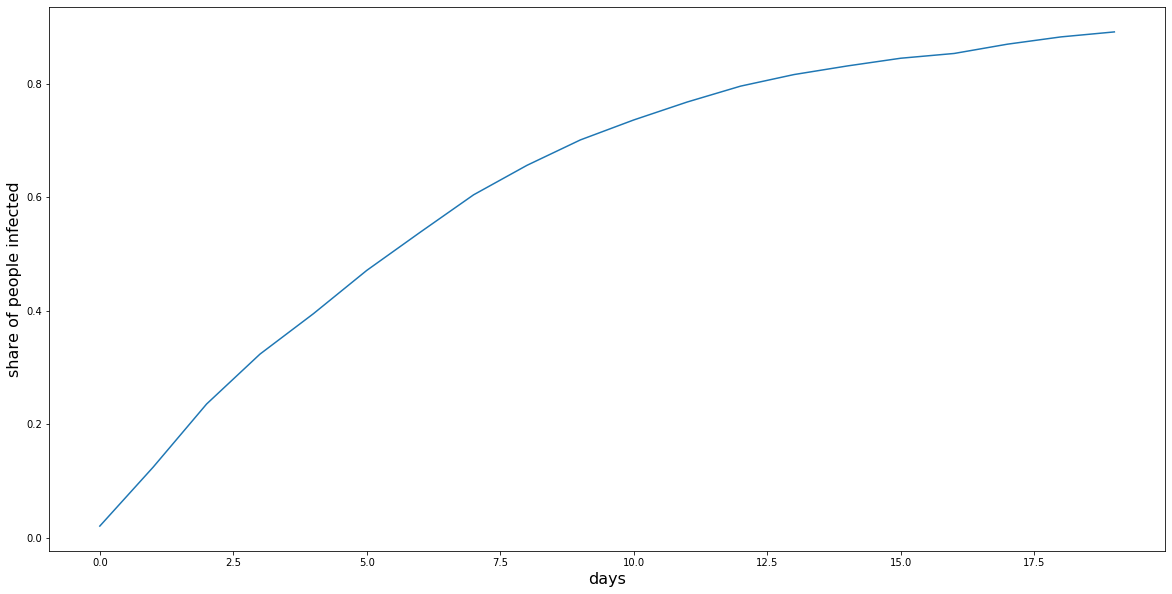

In [76]:
days = list(range(num_days))
infected_share = [n/total_people for n in people_infected]

plt.figure(figsize=(20,10))
plt.plot(days, infected_share)
plt.xlabel('days', fontsize=16)
plt.ylabel('share of people infected', fontsize=16)
plt.show()

## Grid search 1

In [72]:
# keep number of houses below 100 and landmarks below 10 for quick execution while testing

houses_n = 10000
houses1_x = np.random.uniform(0, 800, houses_n//4)
houses1_y = np.random.uniform(0, 200, houses_n//4)
houses2_x = np.random.uniform(800, 1000, houses_n//4)
houses2_y = np.random.uniform(0, 800, houses_n//4)
houses3_x = np.random.uniform(200, 1000, houses_n//4)
houses3_y = np.random.uniform(800, 1000, houses_n//4)
houses4_x = np.random.uniform(0, 200, houses_n//4)
houses4_y = np.random.uniform(200, 1000, houses_n//4)
houses_x = np.concatenate([houses1_x, houses2_x, houses3_x, houses4_x])
houses_y = np.concatenate([houses1_y, houses2_y, houses3_y, houses4_y])

landmarks_n = 50
landmarks_x = np.random.uniform(300, 700, landmarks_n)
landmarks_y = np.random.uniform(300, 700, landmarks_n)

In [73]:
%%time

steps = 11
num_days = 20

app_penetration_grid = np.linspace(start=0, stop=1, num=steps)
ct_compliance_grid = np.linspace(start=0, stop=1, num=steps)

total_people_array = np.zeros((steps, steps))
people_infected_array = np.zeros((steps, steps, num_days))

for i, p_app in enumerate(app_penetration_grid):
    for j, p_comp in enumerate(ct_compliance_grid):

        houses_dict, total_people, people_infected = run_simulation(num_days=num_days, 
                                                                    houses_n=houses_n, 
                                                                    houses_x=houses_x, 
                                                                    houses_y=houses_y, 
                                                                    landmarks_n=landmarks_n, 
                                                                    landmarks_x=landmarks_x, 
                                                                    landmarks_y=landmarks_y, 
                                                                    min_household=1, 
                                                                    max_household=5,
                                                                    app_penetration=p_app,
                                                                    ct_compliance=p_comp, 
                                                                    leave_prob=0.35,
                                                                    public_spread=0.02, 
                                                                    random_spread=0.005, 
                                                                    house_spread=0.5, 
                                                                    display_dicts=False)
        
        total_people_array[i,j] = total_people
        people_infected_array[i,j,:] = people_infected

CPU times: user 1h 3min 10s, sys: 1min 7s, total: 1h 4min 17s
Wall time: 1h 4min 3s


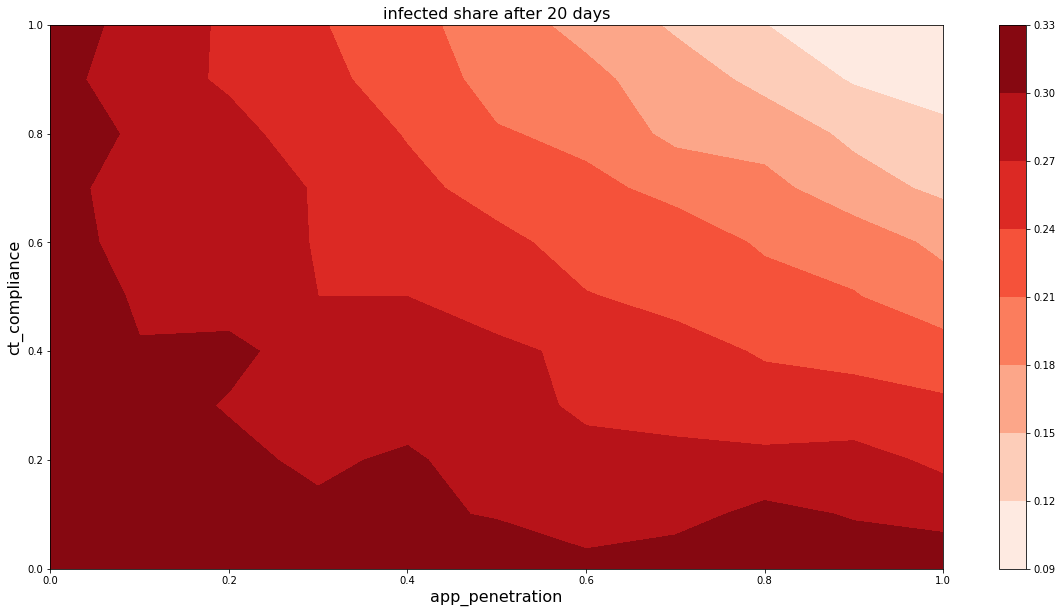

In [77]:
infected_share = np.divide(people_infected_array[:,:,-1], total_people_array)

plt.figure(figsize=(20,10))
plt.contourf(app_penetration_grid, ct_compliance_grid, np.transpose(infected_share),
               cmap='Reds')

plt.title(f'infected share after {num_days} days', fontsize=16)
plt.xlabel('app_penetration', fontsize=16)
plt.ylabel('ct_compliance', fontsize=16)
plt.colorbar()
plt.show()

## Grid search 2

In [ ]:
# Urban
# New York City, New York
# 116 Historic Landmarks - https://en.wikipedia.org/wiki/List_of_National_Historic_Landmarks_in_New_York_City
# 3,154,103 Households - https://www.census.gov/quickfacts/fact/table/newyorkcitynewyork/HSD410218
print(f"New York {int((3154103/116)/100)}x")

# Sprawl
# Austin, Texas
# 2 Historic Landmarks - https://en.wikipedia.org/wiki/List_of_National_Historic_Landmarks_in_Texas
# 370,043 Households - https://www.census.gov/quickfacts/fact/table/austincitytexas/PST045219
print(f"Austin {int((370043/2)/100)}x")

# Average
# Omaha, Nebraska
# 3 Historic Landmarks - https://en.wikipedia.org/wiki/List_of_National_Historic_Landmarks_in_Nebraska
# 183,160 Households - https://www.census.gov/quickfacts/fact/table/omahacitynebraska,US/PST045219
print(f"Omaha {int((183160/3)/100)}x")


In [58]:
houses_n = 500
houses1_x = np.random.uniform(0, 800, houses_n//4)
houses1_y = np.random.uniform(0, 200, houses_n//4)
houses2_x = np.random.uniform(800, 1000, houses_n//4)
houses2_y = np.random.uniform(0, 800, houses_n//4)
houses3_x = np.random.uniform(200, 1000, houses_n//4)
houses3_y = np.random.uniform(800, 1000, houses_n//4)
houses4_x = np.random.uniform(0, 200, houses_n//4)
houses4_y = np.random.uniform(200, 1000, houses_n//4)
houses_x = np.concatenate([houses1_x, houses2_x, houses3_x, houses4_x])
houses_y = np.concatenate([houses1_y, houses2_y, houses3_y, houses4_y])

landmarks_n = 50
landmarks_x = np.random.uniform(300, 700, landmarks_n)
landmarks_y = np.random.uniform(300, 700, landmarks_n)

In [59]:
%%time

steps = 11
num_days = 30
carriers = 0.02        # MedicalNewsToday states 1-3% of people aymptomatic carriers
surface = 0.005        # Small chance of extended time surface transmission
proximate_spread = 0.5 # Change you'll get it from housemates in close proximity
leave_home = 0.35       # Probability you'll leave your home on any day (if you don't have the app)

# Quarantine:
# 35% because 64.6% average drop in mobility in France (mandatory travel restrictions) according to Google Mobility
# https://www.gstatic.com/covid19/mobility/2020-04-17_FR_Mobility_Report_en.pdf
# 95% chance you leave your home on normal day
# 75% chance for city/density studies, since more people will stay out of fear

app_penetration_grid = np.linspace(start=0, stop=1, num=steps)
ct_compliance_grid = np.linspace(start=0, stop=1, num=steps)

total_people_array = np.zeros((steps, steps))
people_infected_array = np.zeros((steps, steps, num_days))

for i, p_app in enumerate(app_penetration_grid):
    for j, p_comp in enumerate(ct_compliance_grid):

        houses_dict, total_people, people_infected = run_simulation(num_days=num_days, 
                                                                    houses_n=houses_n, 
                                                                    houses_x=houses_x, 
                                                                    houses_y=houses_y, 
                                                                    landmarks_n=landmarks_n, 
                                                                    landmarks_x=landmarks_x, 
                                                                    landmarks_y=landmarks_y, 
                                                                    min_household=1, 
                                                                    max_household=5,
                                                                    app_penetration=p_app,
                                                                    ct_compliance=p_comp, 
                                                                    leave_prob=leave_home,
                                                                    public_spread=carriers, 
                                                                    random_spread=surface, 
                                                                    house_spread=proximate_spread, 
                                                                    display_dicts=False)
        
        total_people_array[i,j] = total_people
        people_infected_array[i,j,:] = people_infected

CPU times: user 4min 13s, sys: 1.69 s, total: 4min 15s
Wall time: 4min 16s


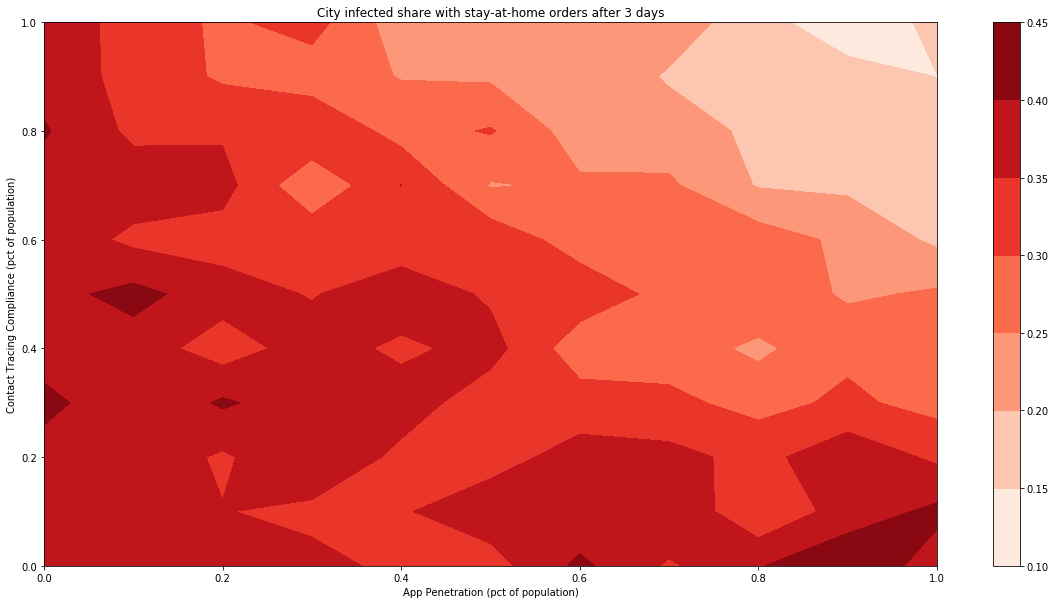

In [71]:
infected_share = np.divide(people_infected_array[:,:,-1], total_people_array)

plt.figure(figsize=(20,10))
plt.contourf(app_penetration_grid, ct_compliance_grid, np.transpose(infected_share),
             cmap="Reds") # vmin=0.2, vmax=0.5

plt.title(f'City infected share with stay-at-home orders after {num_days} days')
plt.xlabel('App Penetration (pct of population)')
plt.ylabel('Contact Tracing Compliance (pct of population)')
plt.colorbar()
plt.show()

## For debugging

In [70]:
houses_n = 10
houses1_x = np.random.uniform(0, 800, houses_n//4)
houses1_y = np.random.uniform(0, 200, houses_n//4)
houses2_x = np.random.uniform(800, 1000, houses_n//4)
houses2_y = np.random.uniform(0, 800, houses_n//4)
houses3_x = np.random.uniform(200, 1000, houses_n//4)
houses3_y = np.random.uniform(800, 1000, houses_n//4)
houses4_x = np.random.uniform(0, 200, houses_n//4)
houses4_y = np.random.uniform(200, 1000, houses_n//4)
houses_x = np.concatenate([houses1_x, houses2_x, houses3_x, houses4_x])
houses_y = np.concatenate([houses1_y, houses2_y, houses3_y, houses4_y])

landmarks_n = 4
landmarks_x = np.random.uniform(300, 700, landmarks_n)
landmarks_y = np.random.uniform(300, 700, landmarks_n)

num_days = 3

houses_dict, _, _ = run_simulation(num_days=num_days, 
                                   houses_n=houses_n, 
                                   houses_x=houses_x, 
                                   houses_y=houses_y, 
                                   landmarks_n=landmarks_n, 
                                   landmarks_x=landmarks_x, 
                                   landmarks_y=landmarks_y, 
                                   min_household=1, 
                                   max_household=3,
                                   app_penetration=1,
                                   ct_compliance=0, 
                                   leave_prob=0.5,
                                   public_spread=0.20, 
                                   random_spread=0.10, 
                                   house_spread=0.50, 
                                   display_dicts=True)


houses_day0


,coordinates,num_people,infected,exposed,infection_present,has_app
0,"(397.3222199143846, 50.6554959954783)",1,[False],[False],False,[True]
1,"(255.55581905186884, 49.25424601228101)",1,[False],[False],False,[True]
2,"(869.5368842710377, 782.9798442325789)",2,"[False, False]","[False, False]",False,"[True, True]"
3,"(836.0124957126341, 580.3979248887381)",1,[False],[False],False,[True]
4,"(967.6026930365487, 810.467447941591)",1,[False],[False],False,[True]
5,"(598.8520343541802, 892.3925875204208)",2,"[False, False]","[False, False]",False,"[True, True]"
6,"(81.10136441553242, 982.7147519526388)",1,[False],[False],False,[True]
7,"(78.22284502013159, 808.1974574213949)",2,"[False, False]","[False, False]",False,"[True, True]"



individuals_in_day0


,house_number,index_number,infected_in,exposed_in,has_app,leave_house,landmark_visit
0,0,0,False,False,True,True,0
1,1,0,False,False,True,True,2
2,2,0,False,False,True,True,2
3,2,1,False,False,True,True,0
4,3,0,False,False,True,False,NaN
5,4,0,False,False,True,False,NaN
6,5,0,False,False,True,False,NaN
7,5,1,False,False,True,True,3
8,6,0,False,False,True,True,2
9,7,0,False,False,True,True,1



landmarks_visitors_day0


,visitors,infection_present
0,"[0, 3]",False
1,[9],False
2,"[1, 2, 8]",False
3,[7],False



individuals_out_day0


,house_number,index_number,infected_in,exposed_in,has_app,leave_house,landmark_visit,exposed_out,infected_out
0,0,0,False,False,True,True,0,False,False
1,1,0,False,False,True,True,2,False,False
2,2,0,False,False,True,True,2,False,False
3,2,1,False,False,True,True,0,False,False
4,3,0,False,False,True,False,NaN,NaN,NaN
5,4,0,False,False,True,False,NaN,NaN,NaN
6,5,0,False,False,True,False,NaN,NaN,NaN
7,5,1,False,False,True,True,3,False,False
8,6,0,False,False,True,True,2,False,False
9,7,0,False,False,True,True,1,False,False



houses_day1


,coordinates,num_people,infected,exposed,infection_present,has_app
0,"(397.3222199143846, 50.6554959954783)",1,[False],[False],False,[True]
1,"(255.55581905186884, 49.25424601228101)",1,[False],[False],False,[True]
2,"(869.5368842710377, 782.9798442325789)",2,"[False, False]","[False, False]",False,"[True, True]"
3,"(836.0124957126341, 580.3979248887381)",1,[False],[False],False,[True]
4,"(967.6026930365487, 810.467447941591)",1,[False],[False],False,[True]
5,"(598.8520343541802, 892.3925875204208)",2,"[False, False]","[False, False]",False,"[True, True]"
6,"(81.10136441553242, 982.7147519526388)",1,[False],[False],False,[True]
7,"(78.22284502013159, 808.1974574213949)",2,"[False, False]","[False, False]",False,"[True, True]"



individuals_in_day1


,house_number,index_number,infected_in,exposed_in,has_app,leave_house,landmark_visit
0,0,0,False,False,True,False,NaN
1,1,0,False,False,True,True,0
2,2,0,False,False,True,True,1
3,2,1,False,False,True,True,1
4,3,0,False,False,True,False,NaN
5,4,0,False,False,True,True,2
6,5,0,False,False,True,False,NaN
7,5,1,False,False,True,True,3
8,6,0,False,False,True,True,0
9,7,0,False,False,True,False,NaN



landmarks_visitors_day1


,visitors,infection_present
0,"[1, 8, 10]",False
1,"[2, 3]",False
2,[5],False
3,[7],False



individuals_out_day1


,house_number,index_number,infected_in,exposed_in,has_app,leave_house,landmark_visit,exposed_out,infected_out
0,0,0,False,False,True,False,NaN,NaN,NaN
1,1,0,False,False,True,True,0,False,False
2,2,0,False,False,True,True,1,False,False
3,2,1,False,False,True,True,1,False,False
4,3,0,False,False,True,False,NaN,NaN,NaN
5,4,0,False,False,True,True,2,False,False
6,5,0,False,False,True,False,NaN,NaN,NaN
7,5,1,False,False,True,True,3,False,False
8,6,0,False,False,True,True,0,False,False
9,7,0,False,False,True,False,NaN,NaN,NaN



houses_day2


,coordinates,num_people,infected,exposed,infection_present,has_app
0,"(397.3222199143846, 50.6554959954783)",1,[False],[False],False,[True]
1,"(255.55581905186884, 49.25424601228101)",1,[False],[False],False,[True]
2,"(869.5368842710377, 782.9798442325789)",2,"[False, False]","[False, False]",False,"[True, True]"
3,"(836.0124957126341, 580.3979248887381)",1,[False],[False],False,[True]
4,"(967.6026930365487, 810.467447941591)",1,[False],[False],False,[True]
5,"(598.8520343541802, 892.3925875204208)",2,"[False, False]","[False, False]",False,"[True, True]"
6,"(81.10136441553242, 982.7147519526388)",1,[False],[False],False,[True]
7,"(78.22284502013159, 808.1974574213949)",2,"[False, False]","[False, False]",False,"[True, True]"



individuals_in_day2


,house_number,index_number,infected_in,exposed_in,has_app,leave_house,landmark_visit
0,0,0,False,False,True,True,2
1,1,0,False,False,True,False,NaN
2,2,0,False,False,True,False,NaN
3,2,1,False,False,True,True,2
4,3,0,False,False,True,True,1
5,4,0,False,False,True,False,NaN
6,5,0,False,False,True,True,0
7,5,1,False,False,True,True,0
8,6,0,False,False,True,False,NaN
9,7,0,False,False,True,True,1



landmarks_visitors_day2


,visitors,infection_present
0,"[6, 7]",False
1,"[4, 9]",False
2,"[0, 3]",False
3,[10],False



individuals_out_day2


,house_number,index_number,infected_in,exposed_in,has_app,leave_house,landmark_visit,exposed_out,infected_out
0,0,0,False,False,True,True,2,False,False
1,1,0,False,False,True,False,NaN,NaN,NaN
2,2,0,False,False,True,False,NaN,NaN,NaN
3,2,1,False,False,True,True,2,False,False
4,3,0,False,False,True,True,1,False,False
5,4,0,False,False,True,False,NaN,NaN,NaN
6,5,0,False,False,True,True,0,False,False
7,5,1,False,False,True,True,0,False,False
8,6,0,False,False,True,False,NaN,NaN,NaN
9,7,0,False,False,True,True,1,True,True


## Appendix

In [ ]:
# leave_prob_exposed vs. leave_prob_not_exposed mesh plot for different values of public_spread
# leave_prob_exposed vs. leave_prob_not_exposed (false positives) mesh plot for different values of public_spread
# low density, medium density, high density

In [ ]:
# Notes:
#     input: accuracy of data
# 
# output 1: spread and peak of spread
# output 2: false positive / false negative
# output 3: tracking spread of infection across geography

In [ ]:
#         f = open(f"data/individuals_in_dict_day{i}.txt","w"); f.write(str(individuals_in_dict)); f.close()
#         f = open(f"data/landmarks_visitors_dict_day{i}.txt","w"); f.write(str(landmarks_visitors_dict)); f.close()
#         f = open(f"data/individuals_out_dict_day{i}.txt","w"); f.write(str(individuals_out_dict)); f.close()
#         f = open(f"data/houses_dict_day{i}.txt","w"); f.write(str(houses_dict)); f.close()

# f = open(f"data/houses_dict_day{i}.csv","w"); w = csv.writer(f); w.writerows(houses_dict.items()); f.close()
# f = open(f"data/individuals_in_dict_day{i}.csv","w"); w = csv.writer(f); w.writerows(individuals_in_dict.items()); f.close()
# f = open(f"data/landmarks_visitors_dict_day{i}.csv","w"); w = csv.writer(f); w.writerows(landmarks_visitors_dict.items()); f.close()
# f = open(f"data/individuals_out_dict_day{i}.csv","w"); w = csv.writer(f); w.writerows(individuals_out_dict.items()); f.close()       

In [ ]:
# plt.figure(figsize=(20,10))
# plt.scatter(houses_x, houses_y, label="houses")
# plt.scatter(landmarks_x, landmarks_y, color="red", label="landmarks")
# plt.legend()
# plt.show()

In [ ]:
# days = list(range(num_days))

# plt.figure(figsize=(20,10))

# for i, p1 in enumerate(ct_compliance_grid):
#     for j, p2 in enumerate(leave_prob_grid):
#         infected_share = [n/total_people for n in people_infected_array[i,j,:]]
#         plt.plot(days, infected_share)

# plt.xlabel('days')
# plt.ylabel('share of people infected')
# plt.show()

In [ ]:
# min_household = 1
# max_household = 5
# app_penetration = 0.2
# ct_compliance = 0.20
# leave_prob = 0.5
# public_spread = 0.10
# random_spread = 0.02
# house_spread = 0.50
# num_days = 20
# display_dicts = False

# houses_dict, total_people, people_infected = run_simulation(num_days, houses_n, houses_x, houses_y, 
#                                                             landmarks_n, landmarks_x, landmarks_y, 
#                                                             min_household, max_household, app_penetration,
#                                                             ct_compliance, leave_prob,
#                                                             public_spread, random_spread, house_spread, 
#                                                             display_dicts)

# days = list(range(num_days))
# infected_share = [n/total_people for n in people_infected]

# plt.figure(figsize=(20,10))
# plt.plot(days, infected_share)
# plt.xlabel('days')
# plt.ylabel('share of people infected')
# plt.show()

In [ ]:
# min_household = 1
# max_household = 5
# app_penetration = 0.2
# ct_compliance = 0.05
# leave_prob = 0.5
# public_spread = 0.10
# random_spread = 0.02
# house_spread = 0.50
# num_days = 20
# display_dicts = False

# houses_dict, total_people, people_infected = run_simulation(num_days, houses_n, houses_x, houses_y, 
#                                                             landmarks_n, landmarks_x, landmarks_y, 
#                                                             min_household, max_household, app_penetration,
#                                                             ct_compliance, leave_prob,
#                                                             public_spread, random_spread, house_spread, 
#                                                             display_dicts)


# days = list(range(num_days))
# infected_share = [n/total_people for n in people_infected]

# plt.figure(figsize=(20,10))
# plt.plot(days, infected_share)
# plt.xlabel('days')
# plt.ylabel('share of people infected')
# plt.show()